Statistical Signal Processing : Denoising with an FIR filter.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from google.colab import drive
from IPython.display import Image
drive.mount('/content/drive')


Mounted at /content/drive


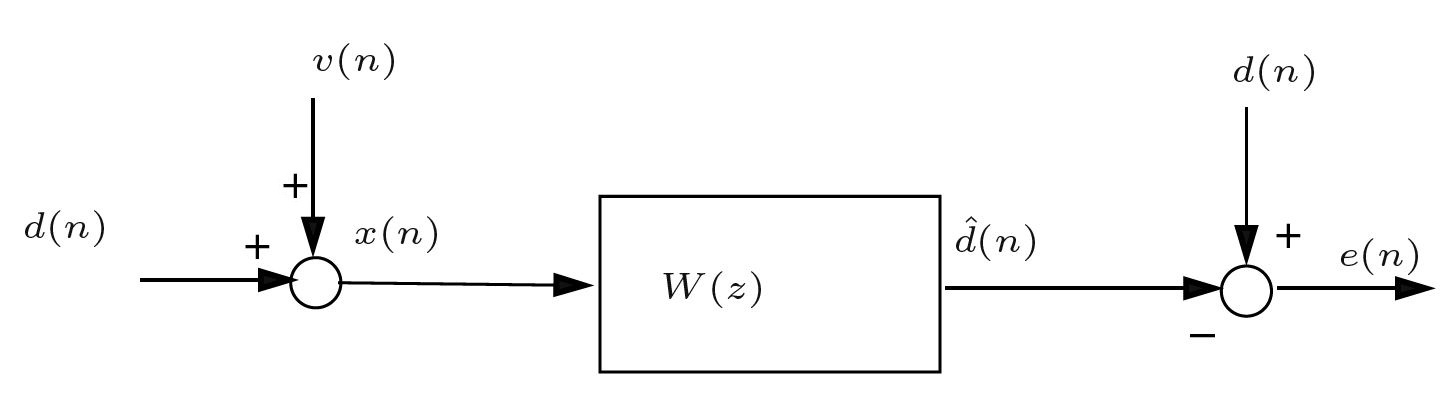

## Introduction

Recent forays into amateur RF communication have led to an exciting breakthrough: the successful transmission of a wireless signal. The setup features a broadcasting antenna paired with a receiving antenna, through which three brief recordings of piano notes were sent. However, upon reception, the recordings were found to be corrupted by noise.

This scenario underscores one of the fundamental challenges in RF communications—dealing with interference. The received signal can be mathematically modeled as

$$x(n) = d(n) + v(n)$$

where $d(n)$ is the original signal of interest and $v(n)$ is additive Gaussian noise that is statistically _uncorrelated_ with $d(n)$.

To mitigate the impact of this noise, the principles of Wiener filtering are applied. By leveraging the statistical properties of both the desired signal and the noise, a finite impulse response (FIR) filter \(W(z)\) can be designed to effectively estimate and recover the original, undistorted signal. All signals in this discussion are considered discrete-time and real, making the approach both practical for real-world applications and a valuable demonstration of statistical signal processing techniques.


### Loading files

As mentioned before, you have three recordings available in the form of `notes_xxx.mat` files, one for each of the tests you ran. Furthermore, you have obtained a recording of the passive noise present in the system (`noise.mat`). Run this section in order to load the `.mat` files with the noise audios and the background noise signals.

In [1]:
pip install sounddevice

In [2]:
!apt-get install -y portaudio19-dev


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libportaudio2 libportaudiocpp0
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 19 not upgraded.
Need to get 188 kB of archives.
After this operation, 927 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudiocpp0 amd64 19.6.0-1.1 [16.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 portaudio19-dev amd64 19.6.0-1.1 [106 kB]
Fetched 188 kB in 1s (283 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 120874 files and directories currently installed.)
Preparing to unpack .../libportaudio2_19.6.0-1.

In [5]:
# packages
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt

import scipy.io as sio
import scipy.linalg as lin
import scipy.signal as sig
import scipy as sp
import math
import time
# use this function to play the signals
# be careful when using headphones!
def play_signal( signal ):
    sd.play( signal.astype('int16'), 22050 )

# notes to be played
notes = np.array( ['Do','Sol','La'] )

# number of experiments
N_exp = notes.shape[0]

print( f'Number of experiments = {N_exp}' )

# list of files for all experiments with audio
filenames = ['/content/drive/MyDrive/ssp_assignment2/notes_do.mat', '/content/drive/MyDrive/ssp_assignment2/notes_sol.mat', '/content/drive/MyDrive/ssp_assignment2/notes_la.mat']
# Number of data points
N = len( sio.loadmat( filenames[0] )['audio'][0] )

# create array with received data
data_noised = np.zeros( (N_exp, N), dtype=float )
for iexp in range(N_exp):
     data_noised[iexp] = sio.loadmat( filenames[iexp] )['audio'][0]

# array for the time steps
time_steps = np.linspace( 0, N-1, N ).astype( int )
print( f'Number of recording time steps = {N}' )

# load background noise signal that was measured

filename_noise = '/content/drive/MyDrive/ssp_assignment2/noise.mat'
data_mat = sio.loadmat( filename_noise )['audio'][0]

filename_noise = '/content/drive/MyDrive/ssp_assignment2/noise.mat'
data_mat = sio.loadmat(filename_noise)['audio'][0]

Nnoise = len( data_mat )
noise_measured = np.array( data_mat, dtype=float )

print( f'Number of noise time steps = {Nnoise}' )

Number of experiments = 3
Number of recording time steps = 40305
Number of noise time steps = 40305


In [ ]:
!pip install pyaudio
!apt-get install portaudio19-dev


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyaudio: filename=PyAudio-0.2.13-cp310-cp310-linux_x86_64.whl size=63864 sha256=b8cbdc2013b6010b8770531e0574278c35e27a6b6d4d7b192cc25aa0ce4f1a70
  Stored in directory: /root/.cache/pip/wheels/14/f1/c2/d102b4765a82c5a7bb273998dca7e4a53fc58e9a1a516fda81
Successfully built pyaudio
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
portaudio19-dev is already the newest version (19.6.0-1.1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [ ]:
import sounddevice as sd

devices = sd.query_devices()
for i, device in enumerate(devices):
     print(f"Device {i}: {device['name']}")



This part should be handled after all audio files were uploaded into *data_noised* array and the noise was uploaded into *noise_measured* file.

**1.** Formulate the denoising problem as a Minimum Variance FIR Wiener Problem, using the symbols $x(n)$, $v(n)$, $d(n)$, $\hat{d}(n)$, $e(n)$ as in the figure presented in the **Introduction**.
No numerical values are required, but you need to specify the meaning of all the symbols and their relation to the sent and received data.


**Answer:**
>$$\min_{W} E[|d(n) - \sum_{k = 0}^{m-1} x(n-k)w(k)|^2]$$

where \\
$x(n) = d(n) + v(n)$ : data_noised, the received data with both signal of interest and noise. \\
$e(n) = d(n) - \hat{d}(n) $: error between the estimation and interest of singnal. \\

$d(n)$: desired signal of interest \\
$v(n)$: noise disturbance \\
$\hat{d}(n)$ : the estimated data

**2.** In the same figure, plot the graphs for the received audio signals in the same figure. Repeat this step in a separate figure for the received noise signal. Label your axes and plots clearly.

Text(0, 0.5, 'Amplitude')

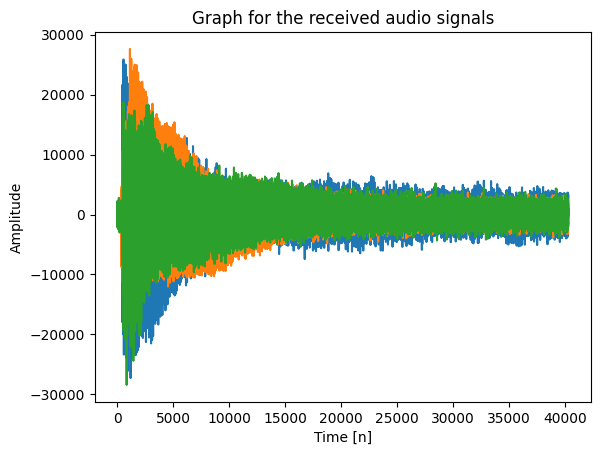

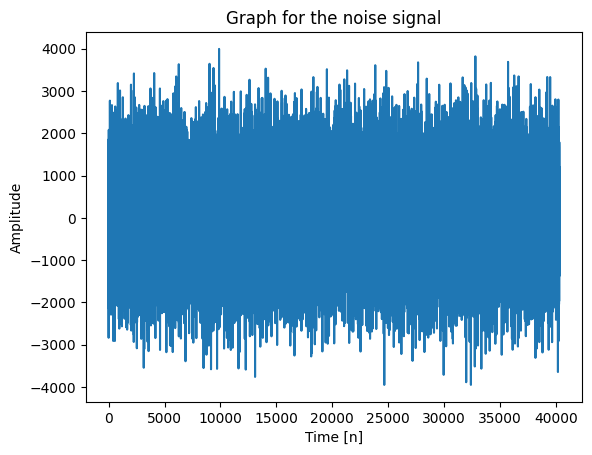

In [6]:
# Implement your plots below

plt.figure()
plt.plot(time_steps,np.transpose(data_noised))
plt.xlabel('Time [n]')
plt.ylabel('Amplitude')
#plt.legend()
plt.title("Graph for the received audio signals")
plt.figure()
plt.plot(time_steps,np.transpose(noise_measured))
plt.title("Graph for the noise signal")
plt.xlabel('Time [n]')
plt.ylabel('Amplitude')

**3.** Using your background noise measurement, estimate its mean and variance ($\sigma^2_v$). Print these estimates.

Next, compute and plot the noise auto-correlation function of the measured noise for lags $=\{0,\ldots,9\}$. Is the signal ZMWN? Explain your answer.

**Computing the autocorrelation as a time average:**

Assuming that the signal $\alpha(n)$  is auto-correlation ergodic,
the auto-correlation function $r_x(k)$ can be estimated as
(if we have only values $\alpha_1, \alpha_2, \dots, \alpha_N$):
$$
    r_\alpha(k) = \frac{1}{N-k} \sum_{i=k+1}^{N} \alpha(i) \alpha^*(i-k)
$$

**Note:** If you are unfamiliar with python, take care when copying `np.arrays`. Read more [here](https://numpy.org/doc/stable/reference/generated/numpy.copy.html). You are not allowed to use the `statsmodels.graphics.tsaplots.plot_acf` and `np.correlate` built-in functions.

In [9]:
# Implement your computations below

mean_v= np.mean(noise_measured)
variance_v=np.var(noise_measured)

### Print mean and variance (DO NOT CHANGE THIS) ###

print('The mean of the noise is', round(mean_v,2))
print('The variance of the noise is', round(variance_v,2))



The mean of the noise is 5.42
The variance of the noise is 1001140.36


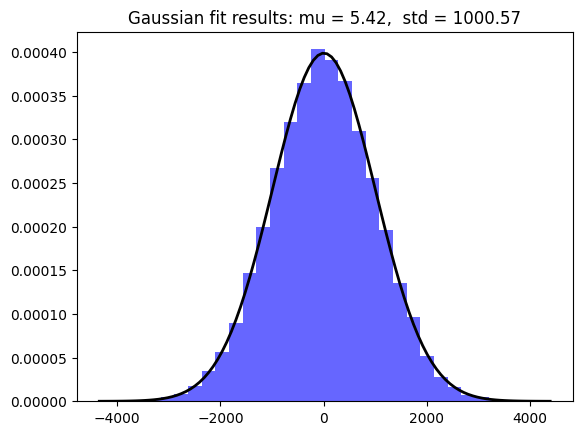

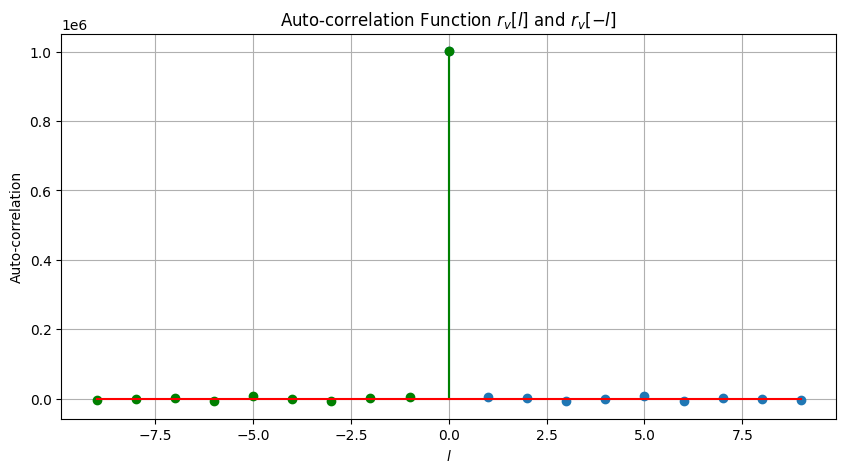

The value of r_v[l] at k=0 is  1001169.7 The variance is equal to  1001140.36


In [10]:
from scipy.stats import norm
from sklearn.metrics import r2_score

# Fit the data to a normal distribution
mu, std = norm.fit(noise_measured)

# Create a histogram of the data
plt.hist(noise_measured, bins=30, density=True, alpha=0.6, color='b')

# Create a PDF (Probability Density Function) for the fitted distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

# Plot the PDF
plt.plot(x, p, 'k', linewidth=2)
title = "Gaussian fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

# Define the range of lags you want to compute
lags = np.arange(0, 10)
N = len(noise_measured)

# Compute auto-correlation function r_X(l) for the specified lags
r_v = np.zeros(len(lags))

for i, lag in enumerate(lags):
    sum_term = 0
    for j in range(lag, N):
        sum_term += noise_measured[j] * np.conj(noise_measured[j - lag])
    r_v[i] = sum_term / (N - lag)

# Plot the auto-correlation function
plt.figure(figsize=(10, 5))
plt.stem(lags, r_v, basefmt="r-")
plt.stem(-lags,r_v,linefmt='g',basefmt="r-")
plt.title('Auto-correlation Function $r_v[l]$ and $r_v[-l]$')
plt.xlabel('$l$')
plt.ylabel('Auto-correlation')
plt.grid(True)
plt.show()

print('The value of r_v[l] at k=0 is ',round(r_v[0],2),'The variance is equal to ', round(variance_v,2))

**Answer:**
>It is checked that the estimated variance($\sigma^2_v$) is equal to the auto-correlation function $r_x(k)$ which is consistent with definition 6.6. Hence we must show that it is WSS and the mean is zero. It can be seen that if we fit the data to a gaussian distribution we have a good fit, implying condition 1 of definition 5.6. In addition, let $\mathcal{L}={1,...,9}$, we can say that $r_x(k) → 0 \; ∀k ∈ \mathcal{L}$ and $r_x(0) ≫ r_x(k) \; ∀k ∈ \mathcal{L}$. Hence the autocorrelation is only dependent on the lag, and the process satisfies condition 5.9 for WSS processes. Furthermore, it can be seen that the variance is finite and positive. Although the mean is not exactly zero, we may assume the process is ZMWN due to the earlier made observations.

**4.** Determine the Wiener-Hopf equation for the denoising case with filter order $m$.
What assumptions are we making for the audio signal and the noise in order to obtain the values of the filter $w$?
Explain how can we calculate the right hand side of the Wiener-Hopf equation assuming that we know $r_x(k), \; \forall k$
and the noise variance $\sigma^2_v$. Make use of mathematical expressions in your explanation.

**Answer:**

>$$\begin{bmatrix}
r_{dx}(0)\\
\vdots\\
r_{dx}(m-1)\\
\end{bmatrix}  = \begin{bmatrix}
r_x(0)&r_x(-1)& \dots &r_x(1-m)\\
r_x(1)& r_x(0)& \dots &r_x(2-m)\\
\vdots & \vdots & \ddots & \vdots\\
r_x(m-1)&r_x(m-2)& \dots &r_x(0) \\
\end{bmatrix}\begin{bmatrix}
\hat{w}(0)\\
\vdots\\
\hat{w}(m-1)\\
\end{bmatrix}$$

By using the fact that $x(n) = d(n) + v(n) $ and $d$ and $v$ are uncorrelated, it is known that $r_{dx} = r_{d}$ and $r_{x} = r_{d} + r_{v}$ where $r_{v}$ = $\sigma^2_v$. The relation that $r_{dx} =r_{d} = r_{x} - \sigma^2_v$ is going to be used in Question 5. To use these equations we must assum thate that the processes $x(n)$ and $d(n)$ are jointly zero mean and WSS.

**5.** Assuming the ergodicity property of the audio signals, compute and plot the auto-correlation function $r_x(k)$ of every received audio signal in separate figures for lags $= \{0,\dots,9\}$. Print these values.

Next, compute and plot the cross-correlation function $r_{dx}(k)$ of every received audio signal in separate figures for lags $= \{0,\dots,9\}$. Print these values. Use your answer in Q3 with your calculations. Label your axes and figures clearly.

**Note:**: You are not allowed to use the `np.correlate`, `statsmodels.graphics.tsaplots.plot_acf`, `np.correlate` and `matplotlib.pyplot.xcorr` built-in functions.

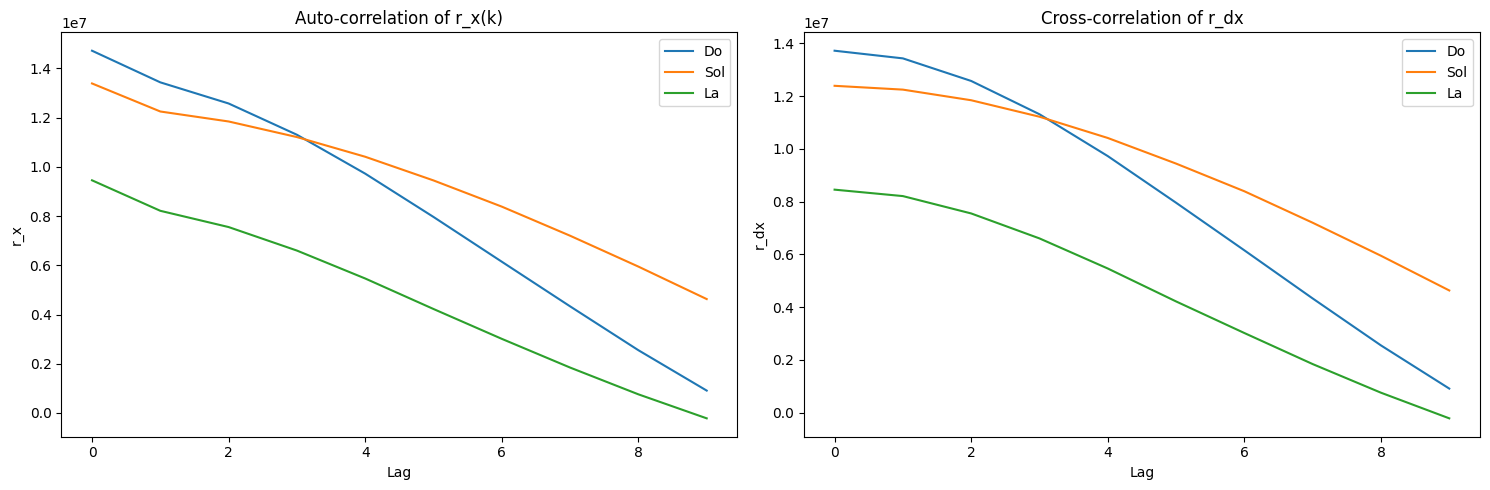

In [11]:
# Implement your computations below
#r_x
# Define the range of lags you want to compute
lags = np.arange(0, 10)

# Initialize arrays to store the auto-correlation for different notes
r_x = []

# Compute auto-correlation for each note
for note_idx in range(3):
    r_x.append(np.zeros(len(lags))) # Initialize auto-correlation array for the current note

    for i, lag in enumerate(lags):
        sum_term = 0
        for j in range(lag, len(data_noised[note_idx])):
            sum_term += data_noised[note_idx][j] * np.conj(data_noised[note_idx][j - lag])
        r_x[note_idx][i] = sum_term / (len(data_noised[note_idx]) - lag)

#r_dx
# Compute variance of the noise from Q3
variance_v = np.var(noise_measured)

# Initialize arrays to store the cross-correlation r_{dx} for each note
r_dx = []

# Compute r_{dx} for each note
for note_idx in range(3):
    # r_dx_note = r_x[note_idx] - variance_v
    r_dx_note = r_x[note_idx] - r_v
    r_dx.append(r_dx_note)


# Implement your plots below
import matplotlib.pyplot as plt

# Define a list of note names for labeling the plots
note_names = ["Do", "Sol", "La"]

# Create a figure with two subplots
plt.figure(figsize=(15, 5))

# Subplot for r_x
plt.subplot(1, 2, 1)
for note_idx in range(3):
    note_name = note_names[note_idx]
    plt.plot(lags, r_x[note_idx], label=f'{note_name}')
plt.title('Auto-correlation of r_x(k)')
plt.xlabel('Lag')
plt.ylabel('r_x')
plt.legend()

# Subplot for r_dx
plt.subplot(1, 2, 2)
for note_idx in range(3):
    note_name = note_names[note_idx]
    plt.plot(lags, r_dx[note_idx], label=f'{note_name}')
plt.title('Cross-correlation of r_dx')
plt.xlabel('Lag')
plt.ylabel('r_dx')
plt.legend()

# Adjust the layout
plt.tight_layout()
plt.show()

In [12]:
### Print results (DO NOT CHANGE THIS) ###

print('The auto-correlation of x(k) for lags 0,...,9 at note Do is', r_x[0])
print('The auto-correlation of x(k) for lags 0,...,9 at note Sol is', r_x[1])
print('The auto-correlation of x(k) for lags 0,...,9 at note La is', r_x[2])

print('The cross-correlation between d(k) and x(k) for lags 0,...,9 at note Do is', r_dx[0])
print('The cross-correlation between d(k) and x(k) for lags 0,...,9 at note Sol is', r_dx[1])
print('The cross-correlation between d(k) and x(k) for lags 0,...,9 at note La is', r_dx[2])

The auto-correlation of x(k) for lags 0,...,9 at note Do is [14718282.87302244 13432835.4355361  12574237.41596738 11303921.93072543
  9723716.28867898  7964475.29673089  6145699.99121735  4332459.12912779
  2550033.306533     909977.0614399 ]
The auto-correlation of x(k) for lags 0,...,9 at note Sol is [13388397.58731672 12248931.436464   11843396.4865134  11210037.10453476
 10410328.20642065  9448092.76830646  8383849.45747197  7201551.05228244
  5947316.30444342  4628319.99494256]
The auto-correlation of x(k) for lags 0,...,9 at note La is [9453376.40832419 8214474.24376716 7553865.29054996 6598904.12589714
 5463974.39853519 4224859.65819529 3012138.4894051  1845523.74522851
  757718.48103536 -217481.58426823]
The cross-correlation between d(k) and x(k) for lags 0,...,9 at note Do is [13717113.17306625 13426853.02394693 12570965.16096668 11309573.46558722
  9723903.8855241   7956150.3389983   6152923.17282512  4329671.8265711
  2550136.74947756   913949.85801924]
The cross-correlati

**6.** Using a 10-th order FIR Wiener filter and your answer in Q3, compute the optimal filter coefficients for every received audio signal. Print these values.

**Note:** The `sp.linalg.toeplitz()` function may be useful. You are not allowed to use the `lin.solve()` or any other built-in solver functions.

In [14]:
import numpy as np
import scipy.linalg as sp

# Define the autocorrelation matrix
a0 = sp.toeplitz(r_x[0])
a1 = sp.toeplitz(r_x[1])
a2 = sp.toeplitz(r_x[2])

# # Calculate the optimal filter coefficients
# w_do = np.linalg.inv(a0) @ r_dx[0]
# w_sol = np.linalg.inv(a1) @ r_dx[1]
# w_la = np.linalg.inv(a2) @ r_dx[2]


w_do=np.dot(np.linalg.inv(a0),r_dx[0])
w_sol=np.dot(np.linalg.inv(a1),r_dx[1])
w_la=np.dot(np.linalg.inv(a2),r_dx[2])

# Store the results in a list
w_opt = [w_do, w_sol, w_la]

# Print the optimal filter coefficients
print('The optimal filter coefficients for Do are:\n', w_opt[0])
print('\nThe optimal filter coefficients for Sol are:\n', w_opt[1])
print('\nThe optimal filter coefficients for La are:\n', w_opt[2])


The optimal filter coefficients for Do are:
 [ 0.5297847   0.33211705  0.14582964  0.0396393  -0.02606231 -0.04860714
 -0.01573974 -0.00918229 -0.01558585 -0.00730424]

The optimal filter coefficients for Sol are:
 [ 4.31131025e-01  3.04495210e-01  1.85229719e-01  9.64259099e-02
  3.67897298e-02 -8.48239918e-03 -7.10660849e-05 -2.66443176e-02
 -3.75840399e-02 -5.96769317e-02]

The optimal filter coefficients for La are:
 [ 0.51378741  0.31802674  0.14420922  0.03972554 -0.01778344 -0.04822712
 -0.01402917 -0.01165684 -0.00934425 -0.01401731]


**7.** Using the computed filter coefficients, compute an estimate of the denoised audio signals from the received ones.

Plot together the denoised signal with the originally received one. Make a plot for every audio signal. Label your axes and figures clearly.

Use the `play_signal()` function in order to play the denoised signals - do you hear the difference between the originally received and the denoised one? Motivate your answer.

**Note:** the `sp.signal.lfilter()` function can be useful when using the Wiener filter.

Text(0, 0.5, 'Amplitude')

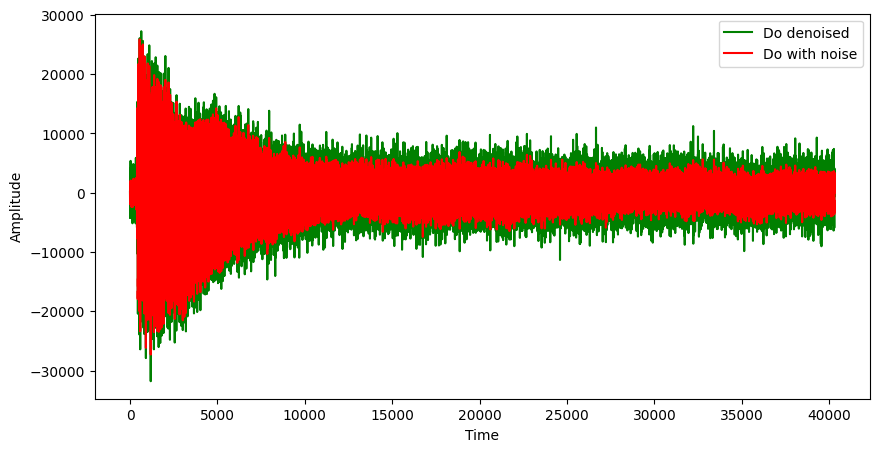

In [16]:
from scipy import signal

# Implement your computations below
d_hat = {'Do' : [],
         'Sol' : [],
         'La' : []}

noise_dic = {'Do' : data_noised[0],
             'Sol' : data_noised[1],
             'La' : data_noised[2]}

for i in range(0,len(list(d_hat.keys()))):
  a = w_opt[i]
  b = np.array([1])
  d_hat[list(d_hat.keys())[i]] = signal.lfilter(b,a,data_noised[i])


plt.figure(figsize=(10,5))
plt.plot(time_steps, d_hat['Do'], color='green', label='Do'+' denoised')
plt.plot(time_steps, noise_dic['Do'], color='red', label='Do'+' with noise')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')

Text(0, 0.5, 'Amplitude')

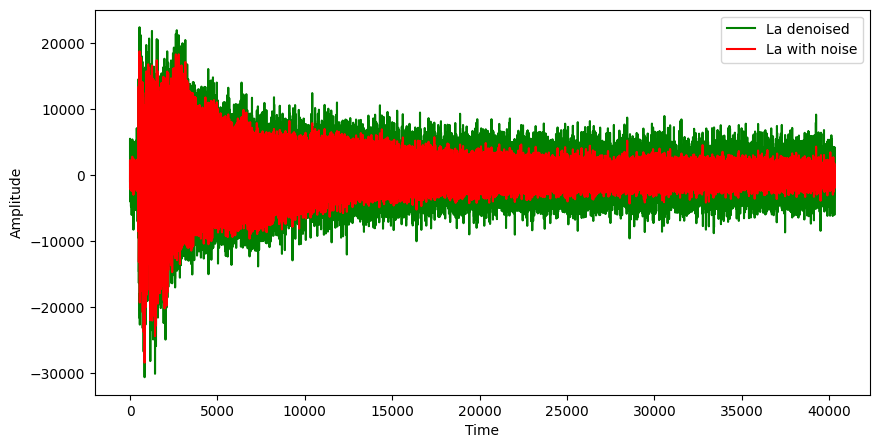

In [18]:
plt.figure(figsize=(10,5))
plt.plot(time_steps, d_hat['La'],color='green', label='La'+' denoised')
plt.plot(time_steps,noise_dic['La'],color='red', label='La'+' with noise')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')

Text(0, 0.5, 'Amplitude')

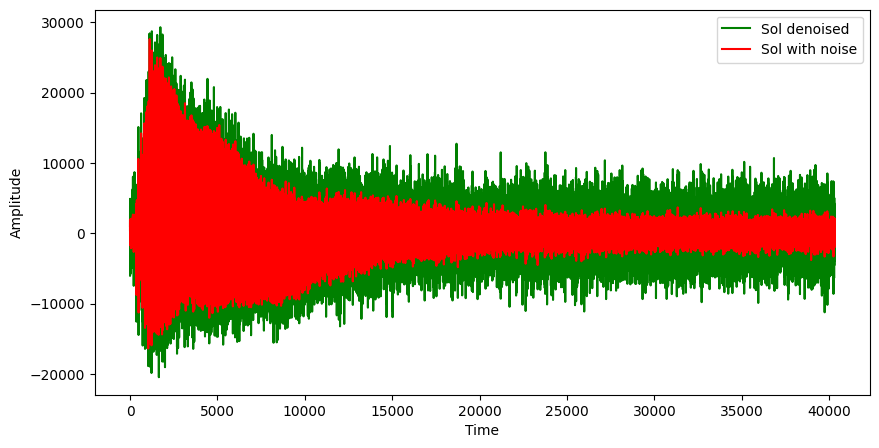

In [19]:
plt.figure(figsize=(10,5))
plt.plot(time_steps, d_hat['Sol'],color='green', label='Sol'+' denoised')
plt.plot(time_steps,noise_dic['Sol'],color='red', label='Sol'+' with noise')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')

**Answer:**
The plot shows primarily that the amplitude is increased. It does not seem like there is a big difference in terms of smoothness.


**8.** You will now attempt to understand what the Wiener filter is doing. To that end we will use the periodogram on the noisy and filtered signals. Compute $P_x$ and $P_{\hat{d}}$ for each recording. For each distance, create two side-by-side plots: the first subplot should show $P_x$ and $P_{\hat d}$ over the whole discrete frequency spectrum $[-\pi, \pi]$ rad/sample, while the second subplot should show the exact same graph but zoomed in on the lower frequencies, e.g. $[-0.8,0.8]$ rad/sample. The $y$-axis should be in decibels, i.e. $20 \log_{10} P$. What do you conclude?

**Note:** Plot first $P_x$ and then overlay on top $P_{\hat d}$. Also play with transparencies to achieve a readable plot. In order to avoid indexing mistakes, it's suggested to use the `np.fft.fftfreq()` function.

          


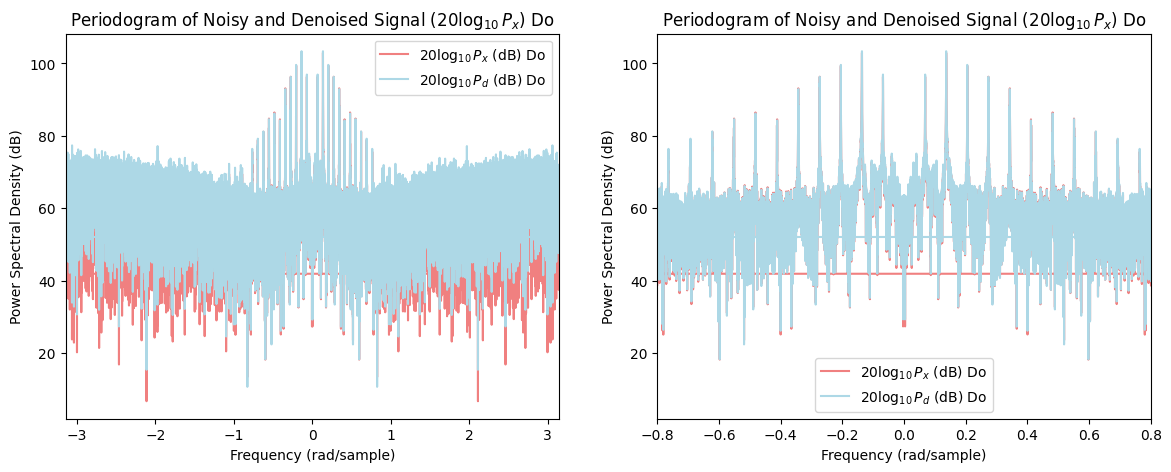

In [20]:
# Implement your compuations below

N = data_noised.shape[-1] #len(noise_measured)
notes = ['Do','Sol','La']
freq = 2*np.pi*np.fft.fftfreq(N)
#Create periodograms
P_x = {}
P_d_hat = {}
for i in range(len(notes)):
  #Original Signal
  X_jw = np.fft.fft(data_noised[i])
  P_x[notes[i]] = (1/(2*N+1))*np.square(np.absolute(X_jw))
  #Denoised Signal
  D_hat_jw = np.fft.fft(d_hat[notes[i]])
  P_d_hat[notes[i]] = (1 / (2 * N + 1)) * np.square(np.absolute(D_hat_jw))


# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Define lighter colors
light_blue = 'lightblue'
light_red = 'lightcoral'


# Plot for the first subplot (xlim between -pi and pi)
ax1.plot(freq, 10 * np.log10(P_x['Do']), label='$20\log_{10}P_x$ (dB) Do', color=light_red, linestyle='solid')
ax1.plot(freq, 10 * np.log10(P_d_hat['Do']), label='$20\log_{10}P_d$ (dB) Do', color=light_blue, linestyle='solid')
ax1.set_xlim([-np.pi, np.pi])
ax1.set_xlabel('Frequency (rad/sample)')
ax1.set_ylabel('Power Spectral Density (dB)')
ax1.set_title('Periodogram of Noisy and Denoised Signal ($20\log_{10}P_x$) Do')
ax1.legend()

# Plot for the second subplot (xlim between -0.8 and 0.8)
ax2.plot(freq, 10 * np.log10(P_x['Do']), label='$20\log_{10}P_x$ (dB) Do', color=light_red, linestyle='solid')
ax2.plot(freq, 10 * np.log10(P_d_hat['Do']), label='$20\log_{10}P_d$ (dB) Do', color=light_blue, linestyle='solid')
ax2.set_xlim([-0.8, 0.8])
ax2.set_xlabel('Frequency (rad/sample)')
ax2.set_ylabel('Power Spectral Density (dB)')
ax2.set_title('Periodogram of Noisy and Denoised Signal ($20\log_{10}P_x$) Do')
ax2.legend()

plt.show()

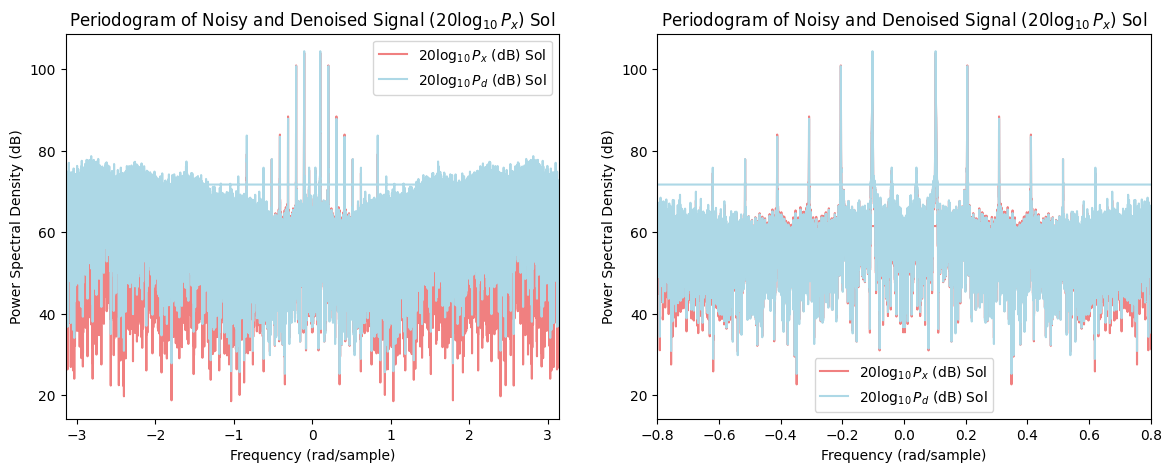

In [21]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Define lighter colors
light_blue = 'lightblue'
light_red = 'lightcoral'

# Plot for the first subplot (xlim between -pi and pi)
ax1.plot(freq, 10 * np.log10(P_x['Sol']), label='$20\log_{10}P_x$ (dB) Sol', color=light_red, linestyle='solid')
ax1.plot(freq, 10 * np.log10(P_d_hat['Sol']), label='$20\log_{10}P_d$ (dB) Sol', color=light_blue, linestyle='solid')
ax1.set_xlim([-np.pi, np.pi])
ax1.set_xlabel('Frequency (rad/sample)')
ax1.set_ylabel('Power Spectral Density (dB)')
ax1.set_title('Periodogram of Noisy and Denoised Signal ($20\log_{10}P_x$) Sol')
ax1.legend()

# Plot for the second subplot (xlim between -0.8 and 0.8)
ax2.plot(freq, 10 * np.log10(P_x['Sol']), label='$20\log_{10}P_x$ (dB) Sol', color=light_red, linestyle='solid')
ax2.plot(freq, 10 * np.log10(P_d_hat['Sol']), label='$20\log_{10}P_d$ (dB) Sol', color=light_blue, linestyle='solid')
ax2.set_xlim([-0.8, 0.8])
ax2.set_xlabel('Frequency (rad/sample)')
ax2.set_ylabel('Power Spectral Density (dB)')
ax2.set_title('Periodogram of Noisy and Denoised Signal ($20\log_{10}P_x$) Sol')
ax2.legend()

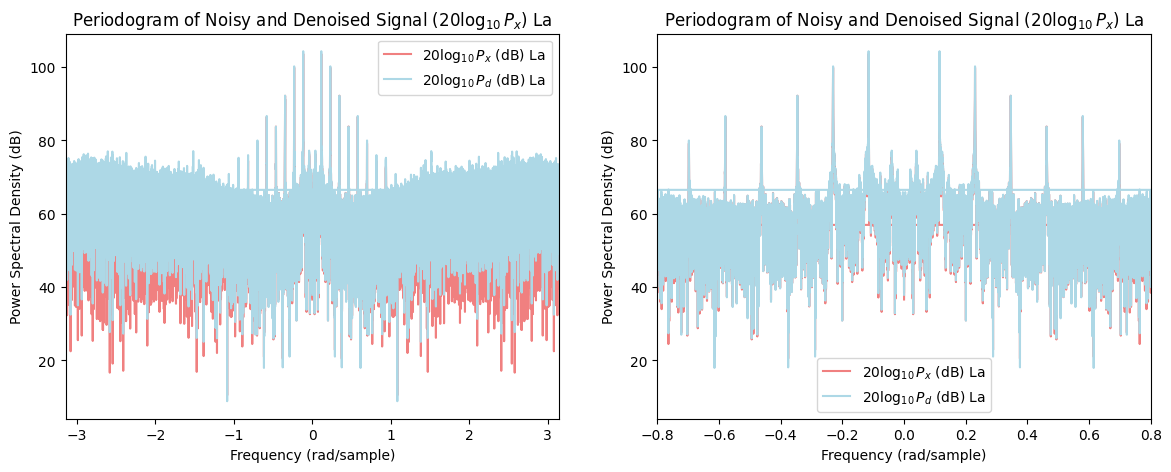

In [22]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Define lighter colors
light_blue = 'lightblue'
light_red = 'lightcoral'

# Plot for the first subplot (xlim between -pi and pi)
ax1.plot(freq, 10 * np.log10(P_x['La']), label='$20\log_{10}P_x$ (dB) La', color=light_red, linestyle='solid')
ax1.plot(freq, 10 * np.log10(P_d_hat['La']), label='$20\log_{10}P_d$ (dB) La', color=light_blue, linestyle='solid')
ax1.set_xlim([-np.pi, np.pi])
ax1.set_xlabel('Frequency (rad/sample)')
ax1.set_ylabel('Power Spectral Density (dB)')
ax1.set_title('Periodogram of Noisy and Denoised Signal ($20\log_{10}P_x$) La')
ax1.legend()

# Plot for the second subplot (xlim between -0.8 and 0.8)
ax2.plot(freq, 10 * np.log10(P_x['La']), label='$20\log_{10}P_x$ (dB) La', color=light_red, linestyle='solid')
ax2.plot(freq, 10 * np.log10(P_d_hat['La']), label='$20\log_{10}P_d$ (dB) La', color=light_blue, linestyle='solid')
ax2.set_xlim([-0.8, 0.8])
ax2.set_xlabel('Frequency (rad/sample)')
ax2.set_ylabel('Power Spectral Density (dB)')
ax2.set_title('Periodogram of Noisy and Denoised Signal ($20\log_{10}P_x$) La')
ax2.legend()

 We can see that the power in the higher frequencies drops off, while in the lower frequencies it stays pretty much the same. In the higher frequencies, where the peaks are too small to notice, we can start to filter away the noise by lowering the power of those frequencies. This result seems logical since noise has a high frequency.

**9.** Now that you've heard the filtered audio, you may naturally be unimpressed with the results. Determined to improve the results you obtained, you decide investigate the effect of the filter order on the estimate of the audio bitstream. To do so, you vary the filter order between $m= 2$ and $m= 500$.
In your experiment, you choose only a single piano key and focus on that audio file.

What filter order would you choose in order to filter the audio signal? Around what number does an increase in filter order no longer yield a significant improvement? Take note that experiementing with large filter orders may require a much longer computation time.

To justify your answer, you may want to look at the value of the cost function $\displaystyle J(w(i)) = \sqrt{E [|e(n;w(i))|^2]} $.

Plot the denoised signal with the filter order of your choice along with the originally received one in the same figure. Play the new audio. Do you notice any improvements over the original audio or the signal obtained with the 10th order filter? Specify the piano key of your choice and remember to label your axes and plots clearly.


The least cost for Do is: 193223.53573860787
The least cost for Sol is: 99223.78005498275
The least cost for La is: 160292.93704447523


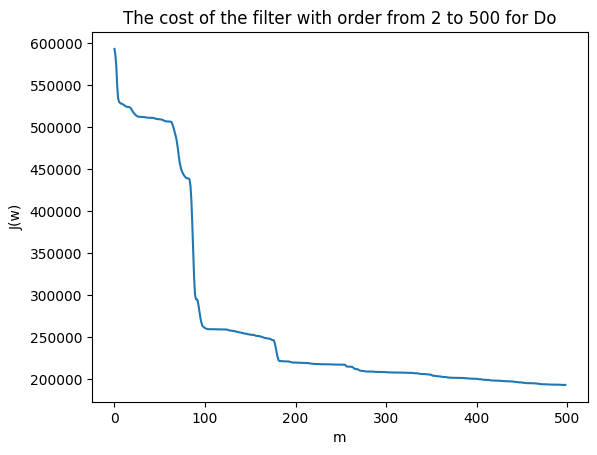

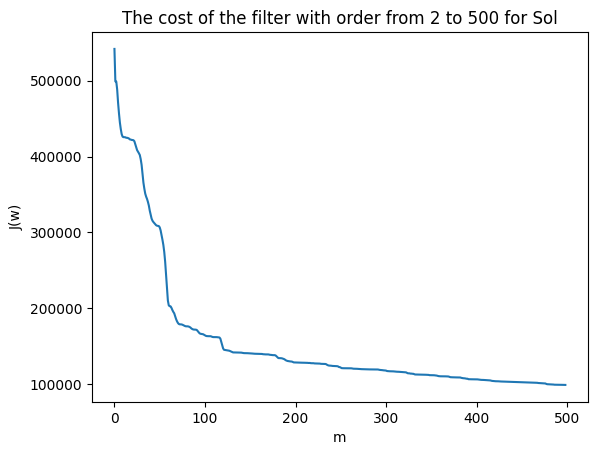

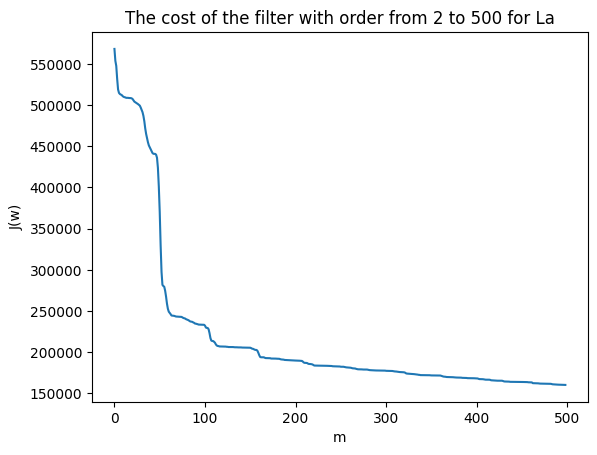

In [ ]:
from scipy.linalg import toeplitz
import numpy as np
import matplotlib.pyplot as plt

# Create a list of data_noised matrices for 'Do,' 'Sol,' and 'La'
notes = ['Do', 'Sol', 'La']
data_noised_dict = {
    'Do': data_noised[0],
    'Sol': data_noised[1],
    'La': data_noised[2]
}

for note in notes:
    # Extract the data for the current note
    data_noised_note = data_noised_dict[note]

    # Compute Rx
    R_x11 = np.zeros(510)
    N = len(data_noised_note)

    for k in range(0, 510):
        sum_term = 0
        for i in range(k + 1, N):
            sum_term += data_noised_note[i] * np.conj(data_noised_note[i - k])
        R_x11[k] = sum_term / (N - k)

    # Compute Rdx
    var_noise = np.var(noise_measured)
    cor_1 = np.zeros(510)
    cor_1[0] = var_noise
    R_dx11 = R_x11 - cor_1

    def Jw(m):
        # Rx
        R_x = np.zeros(m)
        R_x = R_x11[0:m]

        # Rdx
        R_dx = np.zeros(m)
        R_dx = R_dx11[0:m]

        # w
        A = toeplitz(R_x)
        w = np.linalg.inv(A).dot(R_dx)

        # J
        J = R_dx[0] - np.dot(R_dx, w)
        return J

    J1 = np.zeros(499)
    for k in range(2, 501):
        J1[k - 2] = Jw(k)

    Leastcost = np.min(J1)
    print(f'The least cost for {note} is: {Leastcost}')

    # Create a separate plot for each note
    plt.figure()
    plt.plot(J1)
    plt.title(f"The cost of the filter with order from 2 to 500 for {note}")
    plt.xlabel('m')
    plt.ylabel('J(w)')

plt.show()


In [ ]:
import scipy.linalg as sp
import scipy.signal as signal

Bestorder = [180, 110, 160]

# Create a list of data_noised matrices for 'Do,' 'Sol,' and 'La'
notes = ['Do', 'Sol', 'La']
data_noised_dict = {
    'Do': data_noised[0],
    'Sol': data_noised[1],
    'La': data_noised[2]
}

# Create empty arrays to store results for each note
d1_opt_dict = {}

for note in notes:
    data_noised_note = data_noised_dict[note]
    R_x = np.zeros(Bestorder[notes.index(note)])
    N = len(data_noised_note)

    for k in range(0, Bestorder[notes.index(note)]):
        sum_term = 0
        for i in range(k + 1, N):
            sum_term += data_noised_note[i] * np.conj(data_noised_note[i - k])
        R_x[k] = sum_term / (N - k)

    r_v = np.zeros(Bestorder[notes.index(note)])
    N = len(noise_measured)

    for k in range(Bestorder[notes.index(note)]):
        sum_term = 0
        for i in range(k + 1, N):
            sum_term += noise_measured[i] * np.conj(noise_measured[i - k])
        r_v[k] = sum_term / (N - k)

    R_dx = np.zeros(Bestorder[notes.index(note)])
    for k in range(0, Bestorder[notes.index(note)]):
        R_dx[k] = R_x[k] - r_v[k]

    A = sp.toeplitz(R_x)
    w = np.dot(np.linalg.inv(A), R_dx)

    b = np.zeros(Bestorder[notes.index(note)])
    b[0] = 1
    d1_opt = signal.lfilter(w, b, data_noised_note)

    d1_opt_dict[note] = d1_opt


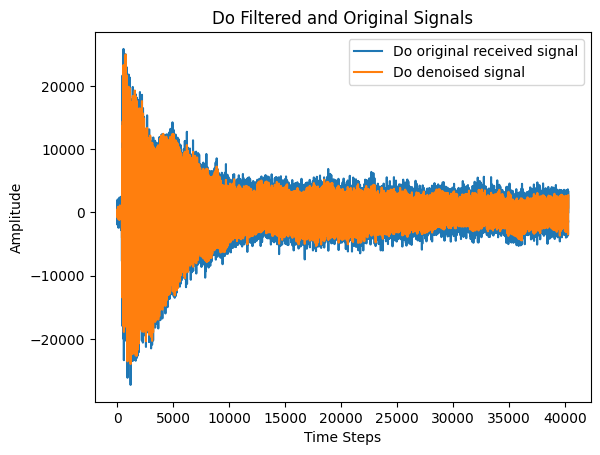

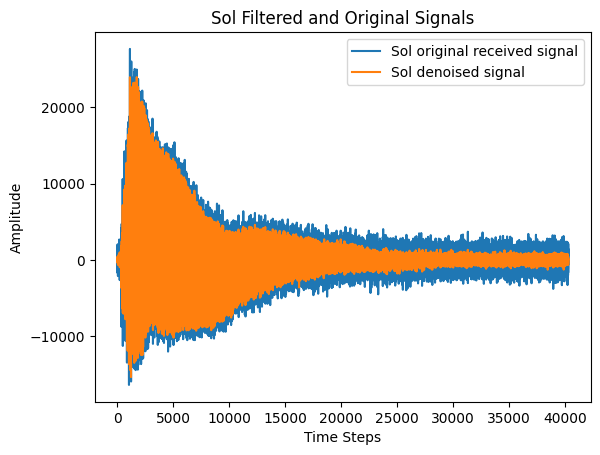

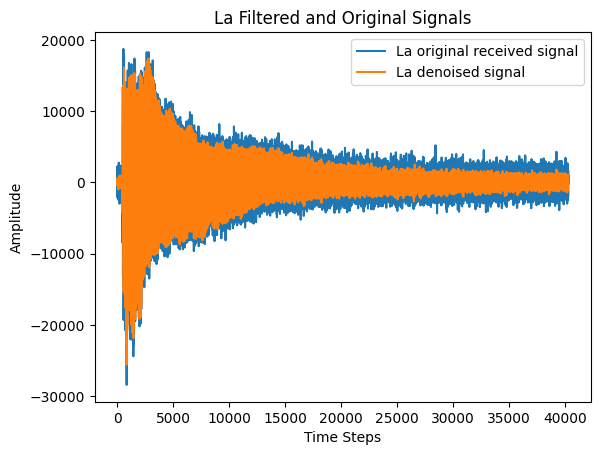

In [ ]:
# Plot each case in separate figures
for note in notes:
    plt.figure()
    plt.plot(time_steps, np.transpose(data_noised_dict[note]), label=f'{note} original received signal')
    plt.plot(time_steps, np.transpose(d1_opt_dict[note]), label=f'{note} denoised signal')
    plt.legend(loc="upper right")
    plt.title(f'{note} Filtered and Original Signals')
    plt.xlabel('Time Steps')
    plt.ylabel('Amplitude')
    plt.show()

In [ ]:
# Play audio
play_signal(data_noised[0,:])#original audio
time.sleep(2)
play_signal(d_hat['Do'])          #fitered by 10th order filter
time.sleep(2)
play_signal(d1_opt_dict['Do'])          #fitered by 180th order filter


# Play audio
play_signal(data_noised[0,:])#original audio
time.sleep(2)
play_signal(d_hat['Sol'])          #fitered by 10th order filter
time.sleep(2)
play_signal(d1_opt_dict['Sol'])          #fitered by 180th order filter

# Play audio
play_signal(data_noised[0,:])#original audio
time.sleep(2)
play_signal(d_hat['La'])          #fitered by 10th order filter
time.sleep(2)
play_signal(d1_opt_dict['La'])          #fitered by 180th order filter